In [1]:
import os

from matplotlib import pyplot as plt
from PIL import Image
import cv2
import numpy as np

import sqlite3

from skimage.measure import label

import open3d as o3d

from tqdm import tqdm

from utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [109]:
perspective = "back"
folder_name = "1"

color_points = np.load(f"created_{perspective}_apple_points3d.npy")
pts3d = color_points[:,:3]
rgb3d = color_points[:,-3:]

front_indices = np.load(f"{perspective}_indices.npy")

with open(f"./{folder_name}/images.txt", "r") as f:
    temp_images = f.readlines()[4:][::2]
img_ids = np.array([x.split(" ")[0] for x in temp_images], dtype=np.int16)
poses = np.array([x.split(" ")[1:8] for x in temp_images], dtype=np.float32)

with open(f"./{folder_name}/cameras.txt", "r") as f:
    temp_cameras = f.readlines()[-1]
cam_params = np.array(temp_cameras.split(" ")[-4:], dtype=np.float32)

con = sqlite3.connect("./database.db")
cur = con.cursor()
img_dict = dict()
for row in cur.execute("SELECT * FROM IMAGES"):
    img_dict[row[0]] = row[1]
con.close()

In [110]:
len(pts3d)

11419

In [111]:
my_pcd = o3d.t.geometry.PointCloud(pts3d)
my_pcd = my_pcd.to_legacy()
my_pcd.colors = o3d.cpu.pybind.utility.Vector3dVector(rgb3d)

my_pcd = my_pcd.farthest_point_down_sample(num_samples=len(pts3d)//10)
down_pts3d = np.asarray(my_pcd.points)

In [112]:
# Read .ply file
# input_file = f"{perspective}.ply"
# front_pcd = o3d.io.read_point_cloud(input_file) # Read the point cloud
# front_pts3d = np.asarray(front_pcd.points)
# front_rgb3d = np.asarray(front_pcd.colors)

# input_file = f"{perspective}_tree_row.ply"
# main_pcd = o3d.io.read_point_cloud(input_file) # Read the point cloud
# main_pts3d = np.asarray(front_pcd.points)
# main_rgb3d = np.asarray(front_pcd.colors)

filenames = [img_dict[idx] for idx in img_ids]
masks_path = "./created_masks/"
images_path = "./images/"
maps = Maps(filenames, masks_path, images_path)

In [113]:
connected_points = []
for i in tqdm(range(len(maps))):
    mask,_ = maps[i]
    extrinsic = get_extrinsic_matrix(poses[i])
    K = get_K_matrix(cam_params)

    mask_labels = label(label_image=mask, return_num=False, connectivity=2)
    apple_points_indices_groups = get_3d_apple_points_from_multiple_masks(pts3d, extrinsic, K, [mask_labels==j for j in range(1, mask_labels.max()+1)])
    for group in apple_points_indices_groups:
        connected_points.append(group)
print(f"number of connected groups: {len(connected_points)}")

100%|██████████| 40/40 [00:10<00:00,  3.80it/s]

number of connected groups: 949


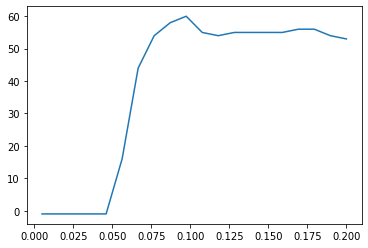

[0.005      0.01526316 0.02552632 0.03578947 0.04605263 0.05631579
 0.06657895 0.07684211 0.08710526 0.09736842 0.10763158 0.11789474
 0.12815789 0.13842105 0.14868421 0.15894737 0.16921053 0.17947368
 0.18973684 0.2       ]


In [115]:
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler

num_clusters = []
eps_vals = np.linspace(0.005, 0.2, 20)
for eps in eps_vals:
    db_model = DBSCAN(eps=eps, min_samples=5)
    labels = db_model.fit_predict(down_pts3d)
    num_clusters.append(labels.max())
plt.plot(eps_vals, num_clusters)
plt.show()
print(eps_vals)

In [116]:
db_model = DBSCAN(eps=0.1, min_samples=2)
labels = db_model.fit_predict(pts3d)

db_clusters = []
for i in range(labels.max()):
    curr_indices = np.where(labels==i)[0]
    if len(curr_indices) >= 2:
        db_clusters.append(curr_indices)

print(f"number of db clusters: {len(db_clusters)}")

number of db clusters: 155


In [117]:
all_connections = connected_points + db_clusters
iset = set([frozenset(s) for s in all_connections if len(s)>0])  # Convert to a set of sets
big_groups = []
while(iset):                  # While there are sets left to process:
    nset = set(iset.pop())      # Pop a new set
    check = len(iset)           # Does iset contain more sets
    while check:                # Until no more sets to check:
        check = False
        for s in iset.copy():       # For each other set:
            if nset.intersection(s):  # if they intersect:
                check = True            # Must recheck previous sets
                iset.remove(s)          # Remove it from remaining sets
                nset.update(s)          # Add it to the current set
    big_groups.append(tuple(nset))  # Convert back to a list of tuples

In [118]:
clusters = []
for group in big_groups:
    num_points = len(group)
    if num_points < 5:
        continue

    clusters.append(pts3d[np.array(group)])
print(f"number of clusters: {len(clusters)}")

number of clusters: 75


In [119]:
cluster_pts3d = np.concatenate(clusters, axis=0)
cluster_rgb3d = np.zeros_like(cluster_pts3d)
k = 0
for n in [len(cluster) for cluster in clusters]:
    rgb = np.random.rand(3)
    cluster_rgb3d[k:k+n] += rgb
    k += n


cluster_pcd = o3d.t.geometry.PointCloud(cluster_pts3d)
cluster_pcd = cluster_pcd.to_legacy()
cluster_pcd.colors = o3d.cpu.pybind.utility.Vector3dVector(cluster_rgb3d)
o3d.io.write_point_cloud(filename=f"{perspective}_combined_clusters.ply", pointcloud=cluster_pcd)

True

In [120]:
from tqdm import tqdm

cluster_images = []

# for each cluster
for cluster in tqdm(clusters):
    # calculate position of cluster in each pose
    cluster_instances = []
    for i in range(len(filenames)):
        extrinsic = get_extrinsic_matrix(poses[i])
        K = get_K_matrix(cam_params)

        cam_pts = get_camera_view(cluster, extrinsic)
        pixel_pts = get_image_view(cam_pts, K)
        inliers = get_in_view_points(pixel_pts)

        if inliers.any():
            has_inlier = True
            rmin, cmin = pixel_pts[:,:2].min(axis=0)
            rmax, cmax = pixel_pts[:,:2].max(axis=0)
            bbox = np.int32(np.round(np.array([rmin, cmin, rmax, cmax])))
            bbox[:2] = np.maximum(0, bbox[:2])
            bbox[2] = min(720, bbox[2])
            bbox[3] = min(1280, bbox[3])

            area = (bbox[2]-bbox[0]) * (bbox[3]-bbox[1])
            if area == 0:
                continue

            filename = filenames[i]

            cluster_instances.append([filename, bbox, area])
    
    cluster_images.append(cluster_instances)

cluster_images = [c for c in cluster_images if len(c) > 0] # remove clusters with no points (because have no area)

100%|██████████| 75/75 [00:00<00:00, 349.22it/s]


In [121]:
len(cluster_images)

75

In [122]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
device = torch.device("cuda")

# Using pretrained weights:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device)
model.fc = torch.nn.Linear(2048, 7, bias=True).to(device)

model.load_state_dict(torch.load("resnet.pt"))
model.eval()

print("Loaded updated model")

Loaded updated model


In [123]:
from torchvision.io import read_image
from torchvision import transforms as T

transform = T.Compose([
    T.Resize((224,224), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

loaded_images = dict()
loaded_masks = dict()
for cluster in tqdm(cluster_images):
    for img_name, _, _ in cluster:
        if not img_name in loaded_images:
            img_path = os.path.join(images_path, img_name)
            image = read_image(img_path) / 255.0
            loaded_images[img_name] = image

            mask_path = os.path.join(masks_path, img_name)
            mask = read_image(mask_path)
            loaded_masks[img_name] = mask

per_cluster_counts = []
biggest_cluster_images = []
for cluster in tqdm(cluster_images):
    images = []
    areas = []
    for img_name, bbox, area in cluster:

        mask = loaded_masks[img_name]
        mask = mask[:,bbox[1]:bbox[3], bbox[0]:bbox[2]]
        mask_area = mask.sum().item()

        if mask_area == 0:
            continue

        # find bbox of mask within cluster's bbox
        rows = np.any(mask[0].numpy(), axis=1)
        cols = np.any(mask[0].numpy(), axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        image = loaded_images[img_name]
        image = image[:,bbox[1]+rmin:bbox[1]+rmax+1, bbox[0]+cmin:bbox[0]+cmax+1]
        image = transform(image.unsqueeze(0))

        images.append(image)
        areas.append(mask_area)

    if len(areas) == 0 or max(areas) == 0:
        per_cluster_counts.append(0)
        biggest_cluster_images.append(None)
        continue

    biggest_images = torch.cat([images[i] for i in np.argsort(areas)[-3:]])
    biggest_cluster_images.append(biggest_images.permute(0,2,3,1).numpy())

    with torch.no_grad():
        pred = model(biggest_images.to(device))
        counts = pred.argmax(dim=1)
        count = torch.median(counts).item()
        per_cluster_counts.append(count)

total = sum(per_cluster_counts)
print(f"total: {total}")

100%|██████████| 75/75 [00:00<00:00, 119.35it/s]

total: 118


front: 192 (126 groups)
back: 118 (75 groups)
total: 310

(array([ 3., 52., 10.,  1.,  3.,  5.,  1.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

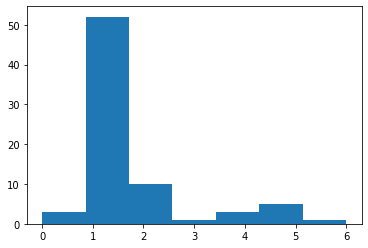

In [124]:
plt.hist(per_cluster_counts, bins=7)

In [125]:
img_idx = 2
cluster_idx = 3
bbox = cluster_images[cluster_idx][img_idx][1]
img_path = os.path.join(images_path, cluster_images[cluster_idx][img_idx][0])
image = read_image(img_path) / 255.0
box_image = image[:,bbox[1]:bbox[3], bbox[0]:bbox[2]]

print(f"number of views: {len(cluster_images[cluster_idx])}")
print(f"predicted count: {per_cluster_counts[cluster_idx]}")

plt.imshow(biggest_cluster_images[cluster_idx][img_idx]/4+0.4)
plt.show()

number of views: 9
predicted count: 1


IndexError: index 2 is out of bounds for axis 0 with size 2